# ****Analyzing StudentPerformance.csv****

**Objective:** To draw inference about whether factors like gender of the student, the race/ethnicity of the student, the level of education of their parents, the type of lunch they ate and whether the completition of test preparation course has any impact on the scores obtained by the student in the tests. 

Some of the questions that this analysis will try to answer are:

1. Does the gender of student plays a role in how they perform in various courses.
2. Does the educational background of the parents impact the students performance.
3. Does the ethnicity of the student has an impact on their performance.
4. Is completing the Test Preparation course help the students in performing better.
5. Does the quality of lunch the students consume leaves an impact on how they perform.

Finally, a model will be trained to predict how the students will perform given the factors influencing their performance and will also evaluate the performance of the model. 

The first step is to import all the necessary libraries needed for performing the analysis:

In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

Exploring the 'StudentPerformance' dataset. 

In [2]:
#reading the StudentsPerformance.csv file and viewing it
student = pd.read_csv("student-data.csv")
student.head()

,Unnamed: 0,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,female,group D,some high school,free/reduced,none,45,65,57
1,1,male,group D,associate's degree,standard,none,88,70,74
2,2,female,group C,bachelor's degree,free/reduced,none,73,81,70
3,3,female,group A,associate's degree,free/reduced,none,47,58,51
4,4,male,group B,high school,standard,completed,81,58,65


As can be seen from the first five rows of the dataset, the dataset contains columns like 'gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score',	'writing score'

In [3]:
#Identifying the columns present in the dataset
student.columns

Index(['Unnamed: 0', 'gender', 'race/ethnicity', 'parental level of education',
       'lunch', 'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [4]:
#This displays general information about the dataset with informations like the column names their data types 
#and the count of non-null values for every column.
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6200 entries, 0 to 6199
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   6200 non-null   int64 
 1   gender                       6200 non-null   object
 2   race/ethnicity               6200 non-null   object
 3   parental level of education  6200 non-null   object
 4   lunch                        6200 non-null   object
 5   test preparation course      6200 non-null   object
 6   math score                   6200 non-null   int64 
 7   reading score                6200 non-null   int64 
 8   writing score                6200 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 436.1+ KB


In [5]:
#checking if there is any column which contains null values
student.isna().sum()

Unnamed: 0                     0
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

So as we can see that there are no null values in any column of the dataset.

Analysing the categorical variables:

In [6]:
#this will help in knowing the number of categories present in each categorical variable
student.select_dtypes('object').nunique()

gender                         2
race/ethnicity                 5
parental level of education    6
lunch                          2
test preparation course        2
dtype: int64

Now as we know the number of unique categories present in each of the categorical variable, it is important to see what are the unique categories present in each of them.

In [7]:
#to find out the various categories present in the different categorical variable
print("Categories in 'gender' variable: ",end=" ")
print(student['gender'].unique())
print("Categories in 'race/ethnicity' variable: ",end=" ")
print(student['race/ethnicity'].unique())
print("Categories in 'parental level of education' variable: ",end=" ")
print(student['parental level of education'].unique())
print("Categories in 'lunch' variable: ",end=" ")
print(student['lunch'].unique())
print("Categories in 'test preparation course' variable: ",end=" ")
print(student['test preparation course'].unique())

Categories in 'gender' variable:  ['female' 'male']
Categories in 'race/ethnicity' variable:  ['group D' 'group C' 'group A' 'group B' 'group E']
Categories in 'parental level of education' variable:  ['some high school' "associate's degree" "bachelor's degree" 'high school'
 'some college' "master's degree"]
Categories in 'lunch' variable:  ['free/reduced' 'standard']
Categories in 'test preparation course' variable:  ['none' 'completed']


In [8]:
#This displays information about the quantitive/numerical columns, information like count, mean, standard deviation, minimum value, maximum value 
#and the quartiles are displayed 
student.describe()

,Unnamed: 0,math score,reading score,writing score
count,6200.000000,6200.000000,6200.000000,6200.000000
mean,3099.500000,66.049355,69.105000,68.145645
std,1789.930166,15.796306,15.528474,16.078908
min,0.000000,-7.000000,14.000000,5.000000
25%,1549.750000,56.000000,59.000000,57.000000
50%,3099.500000,66.000000,70.000000,69.000000
75%,4649.250000,77.000000,80.000000,79.000000
max,6199.000000,108.000000,109.000000,110.000000


We will add a new feature(column) called 'Total Score' which will be basically the sum of the scores obtained in maths, writing and reading for every student. This feature will help in better analysing the overall performance of a student.

In [9]:
#Total score = math score + reading score + writing score
student['Total Score']=student['math score']+student['reading score']+student['writing score']

We will also add a new column 'Pass/Fail', which will basically indicate the status of the student i.e. whether they have passed(P) or failed(F). To decide whether a student have passed we are evaluatin a condition on the total score obtained by the student. We are assuming that the passing criterion if a student has a Total Score of 120 or above then they have Passed, otherwise, they Failed.

In [10]:
#Criterion for getting a passing grade
def result(TS,MS,WS,RS ):
    if(TS>120 and MS>40 and WS>40 and RS>40):
        return 'P'
    else:
        return 'F'
    

In [11]:
student['Pass/Fail']=student.apply(lambda x: result(x['Total Score'],x['math score'],x['writing score'],x['reading score']),axis = 1 )

Let's check the dataset again with the newly added two columns 'Total Score' & 'Pass/Fail'

In [12]:
student.head()

,Unnamed: 0,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Total Score,Pass/Fail
0,0,female,group D,some high school,free/reduced,none,45,65,57,167,P
1,1,male,group D,associate's degree,standard,none,88,70,74,232,P
2,2,female,group C,bachelor's degree,free/reduced,none,73,81,70,224,P
3,3,female,group A,associate's degree,free/reduced,none,47,58,51,156,P
4,4,male,group B,high school,standard,completed,81,58,65,204,P


In [13]:
# student.to_csv('student_data.csv')

Now using the newly added 'Pass/Fail' column, we will count the number of students passed and failed according to the passing criterion:

In [14]:
#Displays the number of students passed and failed according to the passing criterion
student['Pass/Fail'].value_counts()

P    5697
F     503
Name: Pass/Fail, dtype: int64

So according to the count, a total of 939 students have passed and 61 students have failed out of the 1000 students.

Now lets try to visualize the performace of the students, sometimes visualization can help in exploring underlying trends/relationships in a better way:

Text(0.5, 1.0, 'Percentage of students Passed/Failed')

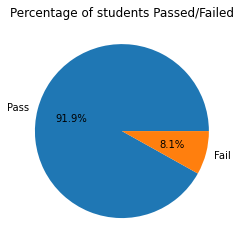

In [15]:
plt.pie(student['Pass/Fail'].value_counts(),labels=['Pass','Fail'],autopct='%1.1f%%')
plt.title('Percentage of students Passed/Failed')

C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Bar-plot representing the count of students passed/failed')

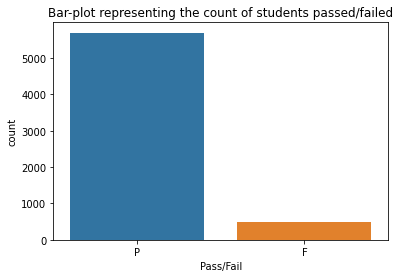

In [16]:
sns.countplot(student['Pass/Fail'])
plt.title('Bar-plot representing the count of students passed/failed')

As the dataset contains both male and female students, we will try to analyze the variation of performance across the gender of the student and will try to findout if one gender performed better than the other

In [17]:
# this displays the number of male and female students in the class
student['gender'].value_counts()

female    3169
male      3031
Name: gender, dtype: int64

So as we can see that out of the 6200 students in the dataset, 3169 are female and 3031 are male. Thus the ratio of male and female students are almost uniform. Now we will try to findout how did the male & female students performed when compared to each other.

In [18]:
#to find out the percentage of female students passed
print("Percentage of female students passed: {0:.2f}%"
    .format((student[(student['gender']=='female') & (student['Pass/Fail']=='P')].shape[0]/student[student['gender']=='female'].shape[0])*100))

#to find out the percentage of male students passed
print("Percentage of male students passed: {0:.2f}%"
    .format((student[(student['gender']=='male') & (student['Pass/Fail']=='P')].shape[0]/student[student['gender']=='male'].shape[0])*100))

Percentage of female students passed: 92.71%
Percentage of male students passed: 91.03%


Therefore from the above analysis we can observe that the male students have overall performed relatively better than the female students

C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Number of students')

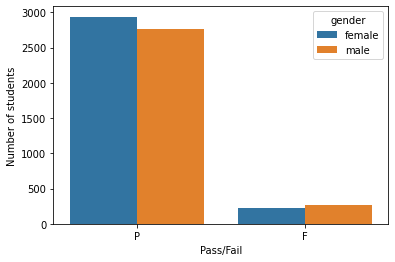

In [19]:
sns.countplot(student['Pass/Fail'],hue = student['gender'])
plt.ylabel('Number of students')

We can observe from the above count plot that there is a variation between how both the genders performed and we can see that the male students have performed overall better than the female students, next we will try to analyze the performance of the students in the three different subjects and their variation across the gender.

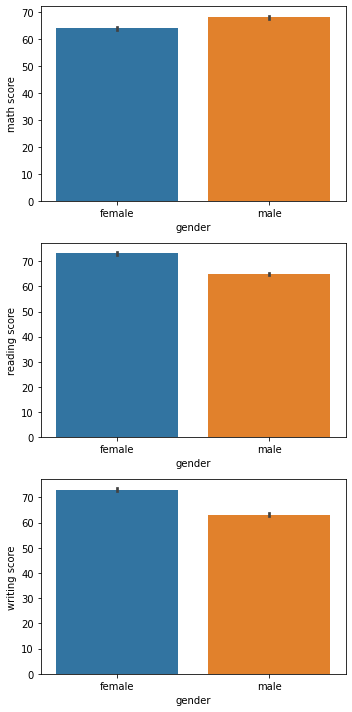

In [20]:
fig,ax = plt.subplots(3,1, figsize = (5,10))
sns.barplot(x=student['gender'],y=student['math score'], ax=ax[0], linewidth=2.5)
sns.barplot(x=student['gender'],y=student['reading score'], ax=ax[1],linewidth=2.5)
sns.barplot(x=student['gender'],y=student['writing score'], ax=ax[2],linewidth=2.5)
plt.tight_layout()

As can be seen from the above barplots that the male students have performed better in maths whereas the female students have relatively performed better than the male students in both reading and writing exams.

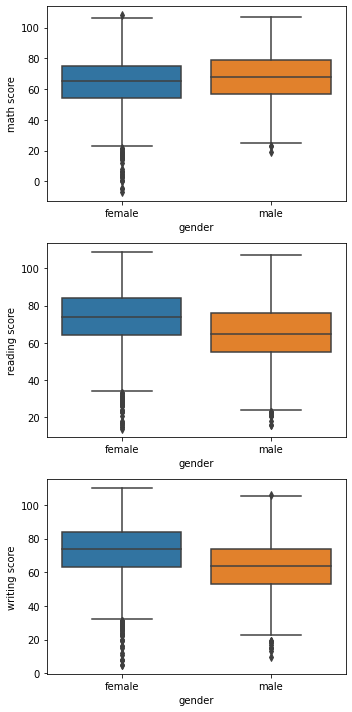

In [21]:
fig,ax = plt.subplots(3,1, figsize = (5,10))
sns.boxplot(x=student['gender'],y=student['math score'],ax=ax[0])
sns.boxplot(x=student['gender'],y=student['reading score'],ax=ax[1])
sns.boxplot(x=student['gender'],y=student['writing score'],ax=ax[2])
plt.tight_layout()

The boxplots represent the performance of the male students vs. the performance of the female students in the three courses separately. As can be seen from the medians and the number of outliers, it can be concluded that the female students performed relatively poorer than the male students in maths but they out-performed the male students in both reading and writing scores. Thus we can conclude that, in this case the performance of a student in a course varies with the gender.

Next, trying to analyse whether the **ethnicity/race** of the student plays any role in their performance.

In [22]:
#number of students belonging to each race/ethnic group
student['race/ethnicity'].value_counts()

group C    1957
group D    1685
group B    1154
group E     831
group A     573
Name: race/ethnicity, dtype: int64

Thus we can see that out of the 1000 students, 319 are from race group C, 262 are from group D,190 are from group B, 140 from group E and 89 are from the race group A. Now we will try to analyse how the students from the different race/ethnic groups have performed compared to each other.

The number of students passed across various race/ethnic group : 
group C    1823
group D    1566
group B    1035
group E     784
group A     489
Name: race/ethnicity, dtype: int64


C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'group D'),
  Text(1, 0, 'group C'),
  Text(2, 0, 'group A'),
  Text(3, 0, 'group B'),
  Text(4, 0, 'group E')])

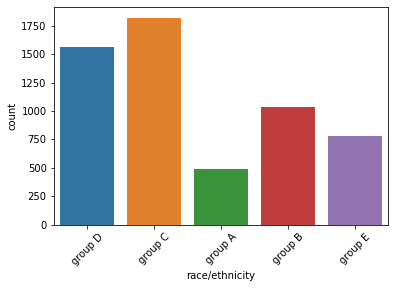

In [23]:
#number of students passed across the race/ethnic groups
print("The number of students passed across various race/ethnic group : ")
print(student['race/ethnicity'].loc[student['Pass/Fail']=='P'].value_counts())
sns.countplot(student['race/ethnicity'].loc[student['Pass/Fail']=='P'])
plt.xticks(rotation = 45)

C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Number of students')

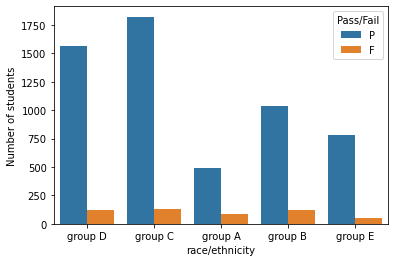

In [24]:
sns.countplot(student['race/ethnicity'],hue=student['Pass/Fail'])
plt.ylabel('Number of students')

In [25]:
#to find out the percentage of students passed with the race/ethnicity  as 'group A'
print("Percentage of students passed with the race/ethnicity  as 'group A': {0:.2f}%"
    .format((student[(student['race/ethnicity']=='group A') & (student['Pass/Fail']=='P')].shape[0]/student[student['race/ethnicity']=='group A'].shape[0])*100))

#to find out the percentage of students passed with the race/ethnicity  as 'group B'
print("Percentage of students passed with the race/ethnicity  as 'group B': {0:.2f}%"
    .format((student[(student['race/ethnicity']=='group B') & (student['Pass/Fail']=='P')].shape[0]/student[student['race/ethnicity']=='group B'].shape[0])*100))

#to find out the percentage of students passed with the race/ethnicity  as 'group C'
print("Percentage of students passed with the race/ethnicity  as 'group C': {0:.2f}%"
    .format((student[(student['race/ethnicity']=='group C') & (student['Pass/Fail']=='P')].shape[0]/student[student['race/ethnicity']=='group C'].shape[0])*100))

#to find out the percentage of students passed with the race/ethnicity  as 'group D'
print("Percentage of students passed with the race/ethnicity  as 'group D': {0:.2f}%"
    .format((student[(student['race/ethnicity']=='group D') & (student['Pass/Fail']=='P')].shape[0]/student[student['race/ethnicity']=='group D'].shape[0])*100))

#to find out the percentage of students passed with the race/ethnicity  as 'group E'
print("Percentage of students passed with the race/ethnicity  as 'group E': {0:.2f}%"
    .format((student[(student['race/ethnicity']=='group E') & (student['Pass/Fail']=='P')].shape[0]/student[student['race/ethnicity']=='group E'].shape[0])*100))


Percentage of students passed with the race/ethnicity  as 'group A': 85.34%
Percentage of students passed with the race/ethnicity  as 'group B': 89.69%
Percentage of students passed with the race/ethnicity  as 'group C': 93.15%
Percentage of students passed with the race/ethnicity  as 'group D': 92.94%
Percentage of students passed with the race/ethnicity  as 'group E': 94.34%


Thus from the above analysis we can observe that the race/ethnicity group 'group E' has performed better than all other groups and the group 'group A' has performed poorer than any other groups. It can also be observed that the performance of students in race/ethinicity group gets better as we move 'group A' to 'group E'.

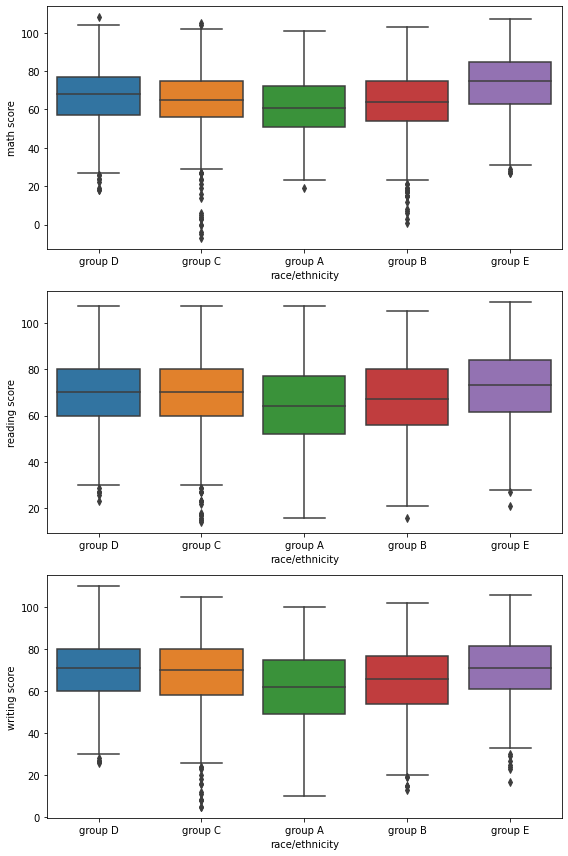

In [26]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
sns.boxplot(x=student['race/ethnicity'],y=student['math score'],ax=ax[0])
sns.boxplot(x=student['race/ethnicity'],y=student['reading score'],ax=ax[1])
sns.boxplot(x=student['race/ethnicity'],y=student['writing score'],ax=ax[2])
plt.tight_layout()

Thus the above observation can also be noted in the above box-plots, 'group A' has a relatively poorer performance in all the three courses whereas in comparison 'group E' performs relatively better than the other groups.

Now we will try to find the impact of the educational background of the parents on the students performance.

In [27]:
#number of students having parents with various edication level
student['parental level of education'].value_counts()

some college          1417
associate's degree    1363
high school           1223
some high school      1088
bachelor's degree      715
master's degree        394
Name: parental level of education, dtype: int64

Thus among the 1000 students, 226 students have parents with 'some college' background, 222 with 'associate's degree',196 have 'high school' background, 179 have parents with 'some high school' background, 118 with 'bachelor's degree',59 with 'master's degree' background. Now we will try to analyze how the performance of the students vary depending on their parents educational background.

The number of students passed across the different parental levels of education: 
some college          1328
associate's degree    1289
high school           1070
some high school       946
bachelor's degree      683
master's degree        381
Name: parental level of education, dtype: int64


C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'some high school'),
  Text(1, 0, "associate's degree"),
  Text(2, 0, "bachelor's degree"),
  Text(3, 0, 'high school'),
  Text(4, 0, 'some college'),
  Text(5, 0, "master's degree")])

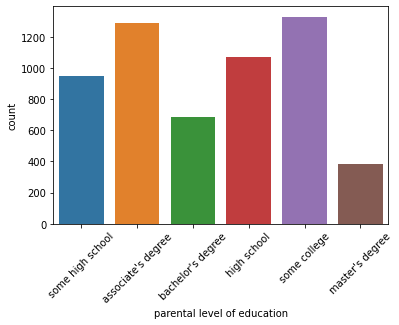

In [28]:
#number of students passed across the parental levels of education 
print("The number of students passed across the different parental levels of education: ")
print(student['parental level of education'].loc[student['Pass/Fail']=='P'].value_counts())
sns.countplot(student['parental level of education'].loc[student['Pass/Fail']=='P'])
plt.xticks(rotation = 45)

In [29]:
#to find out the percentage of students passed with the parental level of education as 'some college'
print("Percentage of students passed with the parental level of education as 'some college': {0:.2f}%"
    .format((student[(student['parental level of education']=='some college') & (student['Pass/Fail']=='P')].shape[0]/student[student['parental level of education']=='some college'].shape[0])*100))

#to find out the percentage of students passed with the parental level of education as 'associate's degree'
print("Percentage of students passed with the parental level of education as 'associate's degree': {0:.2f}%"
    .format((student[(student['parental level of education']=="associate's degree") & (student['Pass/Fail']=='P')].shape[0]/student[student['parental level of education']=="associate's degree"].shape[0])*100))

#to find out the percentage of students passed with the parental level of education as 'high school'
print("Percentage of students passed with the parental level of education as 'high school': {0:.2f}%"
    .format((student[(student['parental level of education']=="high school") & (student['Pass/Fail']=='P')].shape[0]/student[student['parental level of education']=="high school"].shape[0])*100))

#to find out the percentage of students passed with the parental level of education as 'some high school'
print("Percentage of students passed with the parental level of education as 'some high school': {0:.2f}%"
    .format((student[(student['parental level of education']=="some high school") & (student['Pass/Fail']=='P')].shape[0]/student[student['parental level of education']=="some high school"].shape[0])*100))

#to find out the percentage of students passed with the parental level of education as 'bachelor's degree'
print("Percentage of students passed with the parental level of education as 'bachelor's degree': {0:.2f}%"
    .format((student[(student['parental level of education']=="bachelor's degree") & (student['Pass/Fail']=='P')].shape[0]/student[student['parental level of education']=="bachelor's degree"].shape[0])*100))

#to find out the percentage of students passed with the parental level of education as 'master's degree'
print("Percentage of students passed with the parental level of education as 'master's degree': {0:.2f}%"
    .format((student[(student['parental level of education']=="master's degree") & (student['Pass/Fail']=='P')].shape[0]/student[student['parental level of education']=="master's degree"].shape[0])*100))

Percentage of students passed with the parental level of education as 'some college': 93.72%
Percentage of students passed with the parental level of education as 'associate's degree': 94.57%
Percentage of students passed with the parental level of education as 'high school': 87.49%
Percentage of students passed with the parental level of education as 'some high school': 86.95%
Percentage of students passed with the parental level of education as 'bachelor's degree': 95.52%
Percentage of students passed with the parental level of education as 'master's degree': 96.70%


C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Number of students')

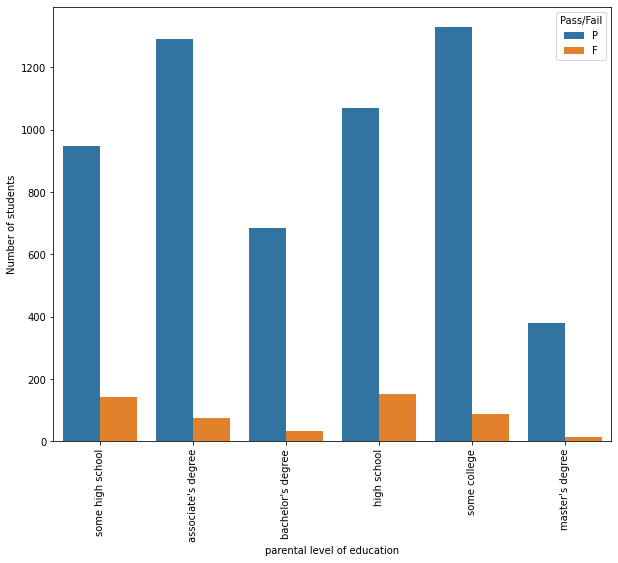

In [30]:
plt.figure(figsize= (10,8))
sns.countplot(student['parental level of education'],hue=student['Pass/Fail'])
plt.xticks(rotation=90)
plt.ylabel('Number of students')

<AxesSubplot:title={'center':'Total Score across parental level of education of students'}, xlabel='parental level of education', ylabel='Total Score'>

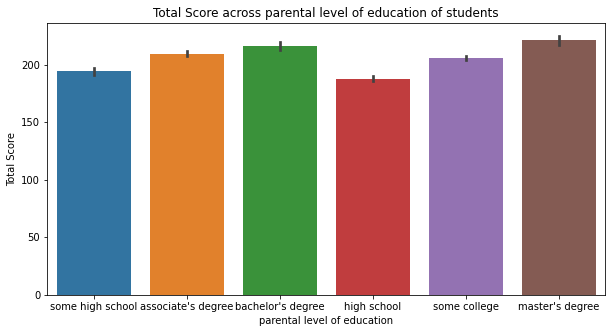

In [31]:
plt.figure(figsize=(10,5))
plt.title("Total Score across parental level of education of students")
sns.barplot(x=student['parental level of education'],y=student['Total Score'])

As can be observed from the above plot that there is some influence the parent's background have on the student's performance. As can be seen, that students having parents with master's degree performed better than other and students with parents having some high school level of education performed poorer than the other groups. 

Next we are going to see how the quality of lunch impacts the performance of the students:

In [32]:
#number of students having 'standard' lunch vs. number of students having 'free/reduced' lunch
student['lunch'].value_counts()

standard        3918
free/reduced    2282
Name: lunch, dtype: int64

Thus out of the 6200 students, 3918 have a standard lunch and 2282 have a free/reduced lunch. Now we will analyze how the type of lunch varies the performance of the students.

In [33]:
#number of students passed across the type of lunch 
student['lunch'].loc[student['Pass/Fail']=='P'].value_counts()

standard        3740
free/reduced    1957
Name: lunch, dtype: int64

C:\Users\HTech\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='lunch', ylabel='count'>

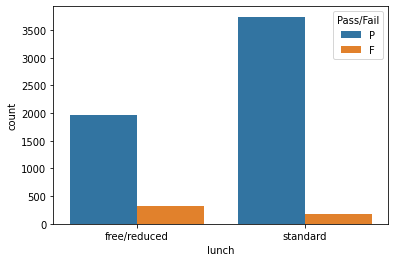

In [34]:
sns.countplot(student['lunch'],hue=student['Pass/Fail'])

In [35]:
#to find out the percentage of students passed with the lunch type as 'standard'
print("Percentage of students passed with the lunch type as 'standard': {0:.2f}%"
    .format((student[(student['lunch']=='standard') & (student['Pass/Fail']=='P')].shape[0]/student[student['lunch']=='standard'].shape[0])*100))

#to find out the percentage of students passed with the lunch type as 'free/reduced'
print("Percentage of students passed with the lunch type as 'free/reduced': {0:.2f}%"
    .format((student[(student['lunch']=="free/reduced") & (student['Pass/Fail']=='P')].shape[0]/student[student['lunch']=="free/reduced"].shape[0])*100))


Percentage of students passed with the lunch type as 'standard': 95.46%
Percentage of students passed with the lunch type as 'free/reduced': 85.76%


<AxesSubplot:title={'center':'Total Score across the type of lunch of the students'}, xlabel='lunch', ylabel='Total Score'>

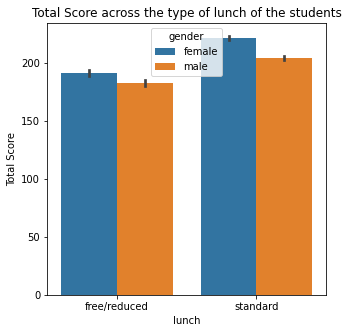

In [36]:
plt.figure(figsize=(5,5))
plt.title("Total Score across the type of lunch of the students")
sns.barplot(x=student['lunch'],y=student['Total Score'],hue=student['gender'])

So as we can observe from the above plot, the type of lunch has an impact on the scores of the students. The students with 'standard' lunch performed better than the student with 'free/reduced' lunch.

Now we are going to find out whether completing the 'Test Preparation Course' helps the students in performing better or not.

In [37]:
#number of students who completed the 'Test preparation course' vs. the students who didn't complete the course
student['test preparation course'].value_counts()

none         3963
completed    2237
Name: test preparation course, dtype: int64

Thus out of the 1000 students, 642 students didn't complete the 'Test preparation course' and 358 students completed it.

In [38]:
#number of students passed across the status of completion of the test preparation course 
print("The number of students passed across the status of completion of the test preparation course:")
print(student['test preparation course'].loc[student['Pass/Fail']=='P'].value_counts())


The number of students passed across the status of completion of the test preparation course:
none         3557
completed    2140
Name: test preparation course, dtype: int64


In [39]:
#to find out the percentage of students passed with the test preparation course status as 'none'
print("Percentage of students passed with the test preparation course status as 'none': {0:.2f}%"
    .format((student[(student['test preparation course']=='none') & (student['Pass/Fail']=='P')].shape[0]/student[student['test preparation course']=='none'].shape[0])*100))

#to find out the percentage of students passed with the test preparation course status as 'completed'
print("Percentage of students passed with the test preparation course status as 'completed': {0:.2f}%"
    .format((student[(student['test preparation course']=="completed") & (student['Pass/Fail']=='P')].shape[0]/student[student['test preparation course']=="completed"].shape[0])*100))


Percentage of students passed with the test preparation course status as 'none': 89.76%
Percentage of students passed with the test preparation course status as 'completed': 95.66%


Text(0.5, 0, 'Status of Test Prep Course')

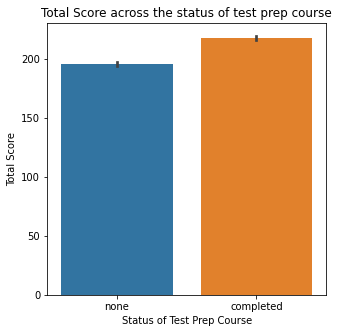

In [40]:
plt.figure(figsize=(5,5))
sns.barplot(x=student['test preparation course'],y=student['Total Score'])
plt.title("Total Score across the status of test prep course")
plt.xlabel('Status of Test Prep Course')

As can be noted that the test preparation course has an impact on the performance of the students, 97.21% of the students who completed the 'Test Preparation Course'passed whereas 92.06% of the students who didn't complete 'Test Preparation Course' passed.

Now we will try to find and observe whether there is any correlation between how the students performed in the various courses.

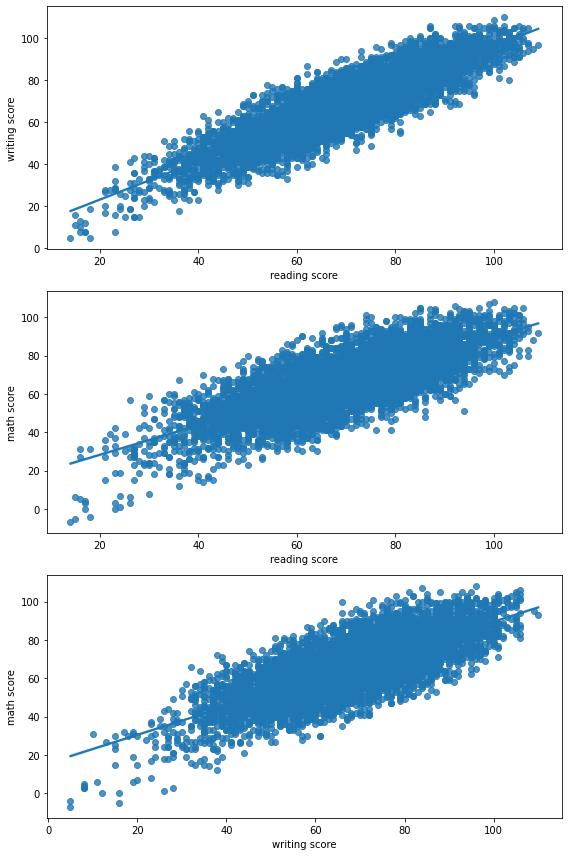

In [41]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
sns.regplot(x=student['reading score'],y=student['writing score'],ax = ax[0])
sns.regplot(x=student['reading score'],y=student['math score'],ax = ax[1])
sns.regplot(x=student['writing score'],y=student['math score'],ax=ax[2])
plt.tight_layout()

As can be seen from the above plots that there is a strong correlation between the scores.
To visualize the correlation in a better way, we produce a heat-map:

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Unnamed: 0'),
  Text(1.5, 0, 'math score'),
  Text(2.5, 0, 'reading score'),
  Text(3.5, 0, 'writing score'),
  Text(4.5, 0, 'Total Score')])

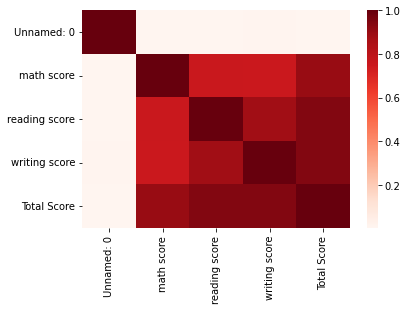

In [42]:
sns.heatmap(student.corr(), cmap ="Reds")
plt.xticks(rotation=90)

As can be observed from the above heat-map that there is a strong correlation between 'reading score' and 'writing score'. The 'math score' is also correlated with the 'reading score' and 'writing score'

So as we have analysed the impact of different features on the student's performance and we observed that factors like 'gender', 'race/ethinicty', 'lunch', 'test preparation course' and 'parental level of education' impacted the scores obtained by the students. 

Now we will try to train a model to be able to predict the **'Pass/Fail'** status of students provided with the features impacting the score of the student.

In [43]:
X=student[['gender','race/ethnicity','parental level of education','lunch','test preparation course']]
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group D,some high school,free/reduced,none
1,male,group D,associate's degree,standard,none
2,female,group C,bachelor's degree,free/reduced,none
3,female,group A,associate's degree,free/reduced,none
4,male,group B,high school,standard,completed


As we know to train a model with categorical variables, they must be first converted into a form which can be utilized for the model fitting purpose. We have used the One Hot Encoding technique to transform the categorical variables.

In [44]:
X_category = student[['gender','race/ethnicity','parental level of education','lunch','test preparation course']]

In [45]:
# Applying one-hot encoding to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [46]:
X_OH = pd.DataFrame(OH_encoder.fit_transform(X_category))
X_OH.index = X_category.index #One-hot encoding removes the index so it's necessary to put them back
X_OH.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [47]:
input = {'gender':'female','race/ethnicity':'group D','parental level of education':'some high school','lunch':'free/reduced','test preparation course':'none'}

In [48]:
df_input = pd.DataFrame(input,index=[0])

In [49]:
input_oh = OH_encoder.transform(df_input)
input_oh

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1.]])

In [50]:
#collecting the total score of the students from the dataset
y=student['Pass/Fail']
y.head()

0    P
1    P
2    P
3    P
4    P
Name: Pass/Fail, dtype: object

In [51]:
lb=LabelEncoder()
y=lb.fit_transform(y)

In [52]:
# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X_OH, y,  test_size=0.4,random_state=1)

In [53]:
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

## Decision tree 

In [54]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [55]:
#model predicting
preds=dt.predict(X_valid)#predictions made by the model

In [56]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [57]:
y_valid

array([1, 1, 1, ..., 1, 1, 1])

In [58]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_valid,preds)
print(round(score*100,2) ,'%')

92.14 %


### saving the decision tree model as it gives the highest accuaracy so we will use for our website

In [59]:
import pickle

In [60]:
# filename = 'finalized_model.sav'
# pickle.dump(model, open(filename, 'wb'))

## SVM Model

In [61]:
model = SVC(kernel = 'rbf',C=0.0001)
model.fit(X_train,y_train)

SVC(C=0.0001)

In [62]:
#model predicting
preds=model.predict(X_valid)#predictions made by the model

In [63]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [64]:
y_valid

array([1, 1, 1, ..., 1, 1, 1])

In [65]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_valid,preds)
print(round(score*100,2) ,'%')

92.02 %


## Linear Regression

In [66]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [67]:
#model predicting
linear_preds=model.predict(X_valid)#predictions made by the model

In [68]:
linear_preds

array([1.03588867, 1.0078125 , 0.9654541 , ..., 0.80957031, 0.84558105,
       0.97558594])

In [69]:
linear_preds= np.where(linear_preds<0.8,0,1)

In [70]:
linear_preds

array([1, 1, 1, ..., 1, 1, 1])

In [71]:
y_valid

array([1, 1, 1, ..., 1, 1, 1])

In [72]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_valid,linear_preds)
print(round(score*100,2) ,'%')

90.32 %


## Prediction 

In [73]:
def student_perfomance_prediction(gender, race, parent_edu, lunch,prep_course):
    X_category = student[['gender','race/ethnicity','parental level of education','lunch','test preparation course']]
    
    # Applying one-hot encoding to each column with categorical data
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    X_OH = pd.DataFrame(OH_encoder.fit_transform(X_category))
    X_OH.index = X.index #One-hot encoding removes the index so it's necessary to put them back
    
    input = {'gender':gender,'race/ethnicity':race,'parental level of education':parent_edu,'lunch':lunch,'test preparation course':prep_course}
    df_input = pd.DataFrame(input,index=[0])
    input_oh = OH_encoder.transform(df_input)
    
    filename = 'finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    
    result = loaded_model.predict(input_oh)
    return result
    

In [74]:
X_category.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group D,some high school,free/reduced,none
1,male,group D,associate's degree,standard,none
2,female,group C,bachelor's degree,free/reduced,none
3,female,group A,associate's degree,free/reduced,none
4,male,group B,high school,standard,completed


In [84]:

X_category['test preparation course'].unique()

array(['none', 'completed'], dtype=object)

In [76]:
a = student_perfomance_prediction('male' ,'group D' ,"master's degree" ,'free/reduced' ,'none' )

In [77]:
a

array([0.89001465])